#Data Generation

In [13]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

The true y = 8x - 2.

In [15]:
w = [8, -2]
data_generate('data.csv', w, 100)

AttributeError: 'numpy.ndarray' object has no attribute 'decode'

#Data Visualization

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


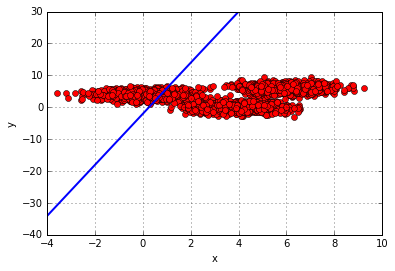

In [18]:
dataPlot('data_regression.csv', w)

#Start Spark

In [10]:
import os
import sys
import pyspark
from pyspark.sql import SQLContext

app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print(sc)
print(sqlContext)


# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd


#Gradient descent (no regularization)

In [11]:
import numpy as np

def linearRegressionGD(data, wInitial=None, learningRate=0.05, iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:  #start learning from a random vector
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:                 #start from provided vector
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)   #make available in memory as read-only to the executors (for mappers and reducers)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w

In [12]:
data = sc.textFile('data.csv').map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
linearRegressionGD(data)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 1 times, most recent failure: Lost task 0.0 in stage 0.0 (TID 0, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 64, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.5 than that in driver 2.7, PySpark cannot run with different minor versions

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.CacheManager.getOrCompute(CacheManager.scala:69)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:268)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 64, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.5 than that in driver 2.7, PySpark cannot run with different minor versions

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.CacheManager.getOrCompute(CacheManager.scala:69)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:268)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


##Plot w in iterations

In [26]:
def ierationsPlot(fileName, truew):
    x = [-4, 4]
    
    w = truew
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'b', label="True line", linewidth=4.0)
    
    data = sc.textFile(fileName).map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
    n = data.count()
    
    np.random.seed(400)
    w = np.random.normal(0,1,2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'r--', label="After 0 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 0 iterations: " + str(squared_error/n)
    

    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'g--', label="After 2 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 2 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'm--', label="After 4 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 4 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'y--', label="After 6 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 6 iterations: " + str(squared_error/n)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

Mean Squared Error after 0 iterations: 464.394955261
Mean Squared Error after 2 iterations: 27.0859380611
Mean Squared Error after 4 iterations: 6.40859048434
Mean Squared Error after 6 iterations: 4.9932567759


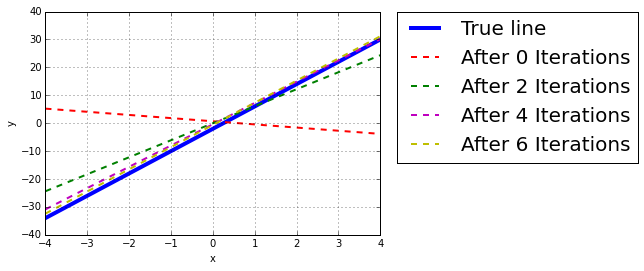

In [27]:
ierationsPlot('data.csv',w)

#Gradient descent (regularization)

In [12]:
def linearRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            #Please fill in code
        elif regType == "Lasso":
            #Please fill in code
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

##Ridge  Regression

In [13]:
np.random.seed(400)
linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Ridge")

array([ 7.98398871, -1.60876051])

##Lasso  Regression

In [14]:
np.random.seed(400)
linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Lasso")

array([ 7.98464511, -1.60861879])

#MLlib Linear Regression

http://spark.apache.org/docs/latest/mllib-linear-methods.html

In [17]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("data.csv")
parsedData = data.map(parsePoint)

# Build the model
model = LinearRegressionWithSGD.train(parsedData, intercept=True, iterations=50)
print model

model_ridge = LinearRegressionWithSGD.train(parsedData, regType="l2", regParam=0.1, intercept=True)
print model_ridge

model_lasso = LinearRegressionWithSGD.train(parsedData, regType="l1", regParam=0.1, intercept=True)
print model_lasso

(weights=[7.98393748404], intercept=-1.6187449131887346)
(weights=[7.84187615307], intercept=-1.4995150386072356)
(weights=[7.96888879755], intercept=-1.5288617888658909)
